In [1]:
# Cross Discipline Big Data Demonstration
# Date July 1, 2022
# Original Author: Peter G. MacHarrie

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import sys
#import cartopy.crs as crs
#import cartopy.feature as cfeature
import json
!{sys.executable} -m pip install PyAthena
import plotly
import plotly.express as px

from pyathena import connect
import pandas as pd

from pyathena.async_cursor import AsyncCursor
import boto3

In [2]:
def q2df(q):
    cursor = connect(s3_staging_dir='s3://esdis-ems-athena', region_name='us-west-2', cursor_class=AsyncCursor).cursor(max_workers=2)
    query_id, future = cursor.execute(q)
    print (query_id, future)
#i=0
#for row in cursor:
#    if i==0:
#        print(row)
#    i+=1
#pd.options.display.float_format = '{:,.4f}'.format
#df = pd.read_sql(q, conn)
#df
    result_set = future.result()
    print(result_set.state)
#    print(result_set.state_change_reason)
#    print(result_set.completion_date_time)
#    print(result_set.submission_date_time)
    print('Data Scanned Bytes:', result_set.data_scanned_in_bytes)
#    print(result_set.engine_execution_time_in_millis)
#    print(result_set.query_queue_time_in_millis)
    print('Total Execution Time (ms):', result_set.total_execution_time_in_millis)
#    print(result_set.query_planning_time_in_millis)
#    print(result_set.service_processing_time_in_millis)
    print('Output location:', result_set.output_location)
#    print(result_set.description)


    s3_client = boto3.client('s3')

    obj=result_set.output_location[result_set.output_location.rfind('/')+1:]
#    print(obj)

    s3_client.download_file('esdis-ems-athena', obj, 'myOut.csv')

    df=pd.read_csv('myOut.csv')  
    return df

In [3]:
def q_ddl(q):
    cursor = connect(s3_staging_dir='s3://esdis-ems-athena', region_name='us-west-2', cursor_class=AsyncCursor).cursor(max_workers=2)
    query_id, future = cursor.execute(q)
    print (query_id, future)
    result_set = future.result()
    print(result_set.state)
#    print(result_set.state_change_reason)
#    print(result_set.completion_date_time)
#    print(result_set.submission_date_time)
    print('Data Scanned Bytes:', result_set.data_scanned_in_bytes)
#    print(result_set.engine_execution_time_in_millis)
#    print(result_set.query_queue_time_in_millis)
    print('Total Execution Time (ms):', result_set.total_execution_time_in_millis)
#    print(result_set.query_planning_time_in_millis)
#    print(result_set.service_processing_time_in_millis)
#    print('Output location:', result_set.output_location)
#    print(result_set.description)
    return

In [4]:
# Basic L2 Data Retreival: N20 air_temp by air_pres + filters, Carribean Region

application_parameters = {
    'table'      : 'sci.climcaps',
    'satellite'  : ['aqua', 'n20'],
    'variables'   : ['apv.air_pres', 'apv.air_temp', 'apv.air_temp', 'apv.air_temp_err', 'apr.air_temp_qc'],
    'begin_date' : '2021-08-21',
    'end_date'   : '2021-08-23',
    'asc_flag'   : '1',
    'qc_flags'   : ['0'],
    'boundingBox': {
        'l_lon' : -100,
        'l_lat' : 17,
        'u_lon' : -65,
        'u_lat' : 34
    }
}

q="""
select 
 sat_name_part, 
 obs_date_part, 
 asc_flag,
 c.obs_time_utc,
 lon, 
 lat, 
 apv.air_pres, 
 apv.air_temp, 
 apv.air_temp_err, 
 apv.air_temp_qc
from 
 sci.climcaps c cross join
 unnest (c.air_pres_vars) t(apv) 
where
 obs_date_part between '2021-08-21' and '2021-08-23'
 and sat_name_part = 'n20'
 and lon between -100 and -65
 and lat  between 17 and 34
-- and apv.air_pres > 80000
 and apv.air_temp_qc in ( '0', '1' )
 and asc_flag ='1'
order by
 sat_name_part, asc_flag, obs_date_part
"""
df=q2df(q)
df

650f5fb3-4ff1-499c-87e3-3f6e684bcaa5 <Future at 0x7f05ed607908 state=running>
SUCCEEDED
Data Scanned Bytes: 413531963
Total Execution Time (ms): 7849
Output location: s3://esdis-ems-athena/650f5fb3-4ff1-499c-87e3-3f6e684bcaa5.csv


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



,sat_name_part,obs_date_part,asc_flag,obs_time_utc,lon,lat,air_pres,air_temp,air_temp_err,air_temp_qc
0,n20,2021-08-21,1,"[2021, 8, 21, 17, 43, 23, 983, 953]",-65.310590,20.630384,2092.236000,222.79904,0.463538,0
1,n20,2021-08-21,1,"[2021, 8, 21, 19, 28, 43, 583, 954]",-95.043260,33.957280,59630.637000,275.70044,0.759256,0
2,n20,2021-08-21,1,"[2021, 8, 21, 17, 46, 51, 183, 957]",-70.360054,32.488434,3.838212,200.74661,1.960814,0
3,n20,2021-08-21,1,"[2021, 8, 21, 19, 28, 2, 983, 954]",-95.945120,31.356697,71.401436,257.75464,0.838022,0
4,n20,2021-08-21,1,"[2021, 8, 21, 17, 43, 23, 983, 953]",-65.310590,20.630384,1858.468600,224.27396,0.690841,0
...,...,...,...,...,...,...,...,...,...,...
434265,n20,2021-08-23,1,"[2021, 8, 23, 18, 50, 10, 783, 959]",-87.127100,31.967113,3227.432600,219.31598,0.451787,0
434266,n20,2021-08-23,1,"[2021, 8, 23, 18, 50, 10, 783, 959]",-87.127100,31.967113,3565.041300,219.00600,0.365296,0
434267,n20,2021-08-23,1,"[2021, 8, 23, 18, 50, 10, 783, 959]",-87.127100,31.967113,3925.658000,218.37534,0.461128,0
434268,n20,2021-08-23,1,"[2021, 8, 23, 18, 50, 10, 783, 959]",-87.127100,31.967113,4310.009000,217.51454,0.654285,0


In [6]:
# Generate 3d Scatter Plot Basic L2 Retreival

df['frame']=df['sat_name_part'] + '_' + df['asc_flag'].astype(str) + '_' + df['obs_date_part']
df['air_pres']= 0 - df['air_pres']
fig=px.scatter_3d(df, 
           x="lon", 
           y="lat",
           z='air_pres',
           animation_frame="frame", 
           range_color=[min(df['air_temp']), max(df['air_temp'])],
           color="air_temp",
           color_continuous_scale='jet',
           title='Air Temperature CLIMCAPS(N20) Ascending Orbit, Carribean Region, Aug 21 Aug 23, 2021',
#           text=['N20 Time: ' + str(df['obs_time_utc'][i]) + '<br>Merra2 Time: ' + str(df['time'][i]) + '<br>N20 AirTemp: ' + str(df['air_temp'][i]) + '<br>MERRA air_temp: ' + str(df["t"][i]) for i, row in df.iterrows() ],
           hover_data=['obs_time_utc', 'air_temp_qc', 'air_temp_err']

          )
fig.write_html("climcaps_air_temp_3d_scatter" + ".html")

In [64]:
# L2 Aggregation: 1x1 degree

q="""
select 
 sat_name_part, 
 asc_flag, 
 round(lon,0) lon, 
 round(lat,0) lat, 
 apv.air_pres, 
 avg(apv.air_temp) air_temp_avg, 
 avg(apv.air_temp_err) air_temp_err_avg,
 count(*) num_obs,
 count(distinct apv.air_pres) num_layers,
 min(obs_time_utc) obs_time_utc_min,
 max(obs_time_utc) obs_time_utc_max,
 array_agg(distinct apv.air_temp_qc) air_temp_qc
from 
 sci.climcaps c cross join
 unnest (c.air_pres_vars) t(apv) 
where
 obs_date_part between '2021-08-21' and '2021-08-23'
 and sat_name_part = 'n20'
-- and lon between -100 and -65
 and lat  between 20 and 25
-- and apv.air_pres > 80000
 and apv.air_temp_qc in ('0', '1')
 and asc_flag = '1'
group by
 sat_name_part, asc_flag, round(lon,0), round(lat,0), apv.air_pres
order by
 sat_name_part, asc_flag"""
df=q2df(q)
df

d51841ed-34d8-4de9-bcf2-ea383d2938c3 <Future at 0x7f97e2cdb978 state=running>
SUCCEEDED
Data Scanned Bytes: 650795045
Total Execution Time (ms): 4851
Output location: s3://esdis-ems-athena/d51841ed-34d8-4de9-bcf2-ea383d2938c3.csv


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



,sat_name_part,asc_flag,lon,lat,air_pres,air_temp_avg,air_temp_err_avg,num_obs,num_layers,obs_time_utc_min,obs_time_utc_max,air_temp_qc
0,n20,1,59.0,22.0,270.08790,248.34938,0.959028,10,1,"[2021, 8, 21, 9, 16, 18, 983, 957]","[2021, 8, 23, 8, 38, 48, 183, 967]",[0]
1,n20,1,59.0,22.0,55516.71000,271.94485,0.618336,10,1,"[2021, 8, 21, 9, 16, 18, 983, 957]","[2021, 8, 23, 8, 38, 48, 183, 967]","[0, 1]"
2,n20,1,55.0,25.0,951.18540,229.44165,0.513951,3,1,"[2021, 8, 21, 9, 17, 21, 783, 965]","[2021, 8, 22, 8, 58, 32, 383, 969]",[0]
3,n20,1,34.0,23.0,587.75946,236.31070,0.856807,8,1,"[2021, 8, 21, 10, 58, 3, 183, 960]","[2021, 8, 22, 10, 39, 21, 583, 966]",[0]
4,n20,1,59.0,24.0,53523.23000,270.20642,0.702029,8,1,"[2021, 8, 21, 9, 16, 51, 183, 958]","[2021, 8, 22, 8, 58, 9, 583, 965]",[0]
...,...,...,...,...,...,...,...,...,...,...,...,...
207643,n20,1,-128.0,25.0,2092.23600,222.78076,0.462030,3,1,"[2021, 8, 21, 21, 8, 0, 383, 967]","[2021, 8, 23, 22, 10, 53, 383, 948]",[0]
207644,n20,1,-125.0,20.0,12564.55300,198.10043,0.431010,2,1,"[2021, 8, 21, 21, 6, 40, 583, 966]","[2021, 8, 21, 21, 6, 40, 783, 966]",[0]
207645,n20,1,-125.0,20.0,25996.91800,235.27916,0.549086,2,1,"[2021, 8, 21, 21, 6, 40, 583, 966]","[2021, 8, 21, 21, 6, 40, 783, 966]",[0]
207646,n20,1,-125.0,20.0,87862.03000,289.44150,0.954869,2,1,"[2021, 8, 21, 21, 6, 40, 583, 966]","[2021, 8, 21, 21, 6, 40, 783, 966]",[1]


In [50]:
#Plot basic aggregation

df['frame']=df['sat_name_part'] + '_' + df['asc_flag'].astype(str)
df['air_pres']= 0 - df['air_pres']
fig=px.scatter_3d(df, 
           x="lon", 
           y="lat",
           z='air_pres',
           animation_frame="frame", 
           range_color=[min(df['air_temp_avg']), max(df['air_temp_avg'])],
           color="air_temp_avg",
           color_continuous_scale='jet',
            title='Average Air Temperature CLIMCAPS(N20) Ascending Orbit, 20-25 Degree North, 1x1 Degree Aggregation Aug 21 - 23, 2021',
#           text=['N20 Time: ' + str(df['obs_time_utc'][i]) + '<br>Merra2 Time: ' + str(df['time'][i]) + '<br>N20 AirTemp: ' + str(df['air_temp'][i]) + '<br>MERRA air_temp: ' + str(df["t"][i]) for i, row in df.iterrows() ],
           hover_data=['obs_time_utc_min', 'obs_time_utc_max', 'air_temp_qc', 'num_obs', 'air_temp_err_avg']

          )
fig.write_html("climcaps_air_temp_agg_3d_scatter" + ".html")

In [7]:
# CLIMCAPS h2o >= 1.00e26 ~ 7.0 degrees of Tropical Storm / Hurricane Center Ida 2021
q="""
select distinct
 c.sat_name_part,
 c.obs_date_part,
 c.lon, 
 c.lat, 
 asc_flag,
 date_parse(cast(c.obs_time_utc[1] as varchar) ||'-'|| cast(c.obs_time_utc[2] as varchar) ||'-'|| cast(c.obs_time_utc[3] as varchar) ||'T'|| cast(c.obs_time_utc[4] as varchar) ||':'|| cast(c.obs_time_utc[5] as varchar), '%Y-%c-%eT%k:%i'),
 0.0 - apv.air_pres_lay air_pres_lay,
 apv.h2o_vap_mol_lay 
from 
 sci.climcaps c cross join unnest (c.air_pres_lay_vars) t(apv),
 climcaps_work_area.hurricane_ida h
where
 c.lon between h.lon - 8.5 and h.lon + 8.5
 and c.lat between h.lat - 8.5 and h.lat + 8.5
 and date_parse(cast(c.obs_time_utc[1] as varchar) ||'-'|| cast(c.obs_time_utc[2] as varchar) ||'-'|| cast(c.obs_time_utc[3] as varchar) ||'T'|| cast(c.obs_time_utc[4] as varchar) ||':'|| cast(c.obs_time_utc[5] as varchar), '%Y-%c-%eT%k:%i')
 between h.obs_date_time - interval '5' hour and h.obs_date_time + interval '5' hour
 and apv.h2o_vap_mol_lay >= 1.00e26
 and apv.h2o_vap_mol_lay_qc in ('0', '1')
order by
 c.obs_date_part, asc_flag, c.sat_name_part, c.lon, 0.0 - apv.air_pres_lay
"""
df=q2df(q)
df


0f55d7b6-2027-45ee-b30e-f43c87c16aaf <Future at 0x7f0615471f98 state=running>
SUCCEEDED
Data Scanned Bytes: 2814123687
Total Execution Time (ms): 17229
Output location: s3://esdis-ems-athena/0f55d7b6-2027-45ee-b30e-f43c87c16aaf.csv


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



,sat_name_part,obs_date_part,lon,lat,asc_flag,_col5,air_pres_lay,h2o_vap_mol_lay
0,aqua,2021-08-26,-83.9584,24.455479,1,2021-08-26 18:22:00.000,-97223.203125,1.559542e+26
1,aqua,2021-08-26,-83.9584,24.455479,1,2021-08-26 18:22:00.000,-94496.000000,1.512255e+26
2,aqua,2021-08-26,-83.9584,24.455479,1,2021-08-26 18:22:00.000,-91809.796875,1.441409e+26
3,aqua,2021-08-26,-83.9584,24.455479,1,2021-08-26 18:22:00.000,-89164.601562,1.372261e+26
4,aqua,2021-08-26,-83.9584,24.455479,1,2021-08-26 18:22:00.000,-86560.796875,1.107312e+26
...,...,...,...,...,...,...,...,...
65835,n20,2021-08-31,-77.7235,37.155342,1,2021-08-31 18:00:00.000,-94496.000000,1.256799e+26
65836,n20,2021-08-31,-77.7235,37.155342,1,2021-08-31 18:00:00.000,-91809.796875,1.238976e+26
65837,n20,2021-08-31,-77.7235,37.155342,1,2021-08-31 18:00:00.000,-89164.601562,1.218947e+26
65838,n20,2021-08-31,-77.7235,37.155342,1,2021-08-31 18:00:00.000,-86560.796875,1.176522e+26


In [8]:
df['frame']=df['sat_name_part'] + '_' + df['asc_flag'].astype(str) + '_' + df['obs_date_part']
fig=px.scatter_3d(df, 
           x="lon", 
           y="lat",
           z='air_pres_lay',
           animation_frame="frame", 
           range_color=[min(df['h2o_vap_mol_lay']), max(df['h2o_vap_mol_lay'])],
           color="h2o_vap_mol_lay",
           color_continuous_scale='jet'
          )
fig.write_html("climcaps_ida_h2o_vap_mol_lay" + ".html")

In [53]:
# Find the hottest and coldest observations

q="""
with t1 as (
select
 min(surf_air_temp) surf_air_temp_min,
 max(surf_air_temp) surf_air_temp_max 
from 
 sci.climcaps c
where 
 sat_name_part = 'n20' and 
 surf_air_temp_qc in ( '0', '1')
)
select 
 sat_name_part,
 asc_flag,
 lon,
 lat,
 obs_time_utc,
 surf_air_temp,
 t1.surf_air_temp_min,
 t1.surf_air_temp_max
from 
    sci.climcaps c,
    t1
where 
 surf_air_temp = t1.surf_air_temp_min or surf_air_temp =  t1.surf_air_temp_max
"""

df=q2df(q)
df


# Total Data Stored: 53,000 MB
# Total Data Read. :    118 MB

2bba98df-c04d-46c4-abe1-e7bf505b20a9 <Future at 0x7f97e30e0da0 state=running>
SUCCEEDED
Data Scanned Bytes: 118312044
Total Execution Time (ms): 2916
Output location: s3://esdis-ems-athena/2bba98df-c04d-46c4-abe1-e7bf505b20a9.csv


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



,sat_name_part,asc_flag,lon,lat,obs_time_utc,surf_air_temp,surf_air_temp_min,surf_air_temp_max
0,n20,1,144.85526,-85.949580,"[2021, 8, 27, 8, 32, 24, 983, 964]",192.17522,192.17522,322.23312
1,n20,1,47.82617,31.628725,"[2021, 8, 27, 9, 7, 3, 983, 967]",322.23312,192.17522,322.23312


In [9]:
# Generate Weekly 10th dergree Sea Surface Temperature Statistics over Carribean.
# Retrieve "pixels" +- 3 standard deviations from mean. (min 100 observations)
q="""
with t1 as (
select
 week(time_base) week, 
 round(longitude, 1) longitude_10th,
 round(latitude, 1) latitude_10th,
 avg(sea_surface_temperature) sst_avg,
 stddev(sea_surface_temperature) sst_stddev,
 min(sea_surface_temperature)    sst_min,
 max(sea_surface_temperature)    sst_max,
 count(*) obs_count
from 
 sci.abi_g16_star_l2p_v2_70 g
where 
hour(time_base) = 17
and g.longitude between -100 and -76
and g.latitude  between 15  and 31
group by 
 1,2,3
order by 2,1,3
)
select
 g.time_base,
 date_format(g.time_base, '%Y-%m-%d') date,
 g.longitude,
 g.latitude,
 g.sea_surface_temperature,
 t1.sst_avg,
 t1.sst_stddev,
 t1.obs_count,
 (g.sea_surface_temperature - t1.sst_avg) / t1.sst_stddev sst_sigma
from 
 t1, 
 sci.abi_g16_star_l2p_v2_70 g
where 
 g.time_base between timestamp '2021-08-20' and timestamp '2021-08-26'
 and round(g.latitude, 1) = t1.latitude_10th   
 and round(g.longitude, 1) = t1.longitude_10th
 and week(time_base) = t1.week
 and hour(time_base) = 17
 and t1.obs_count > 100
 and abs((g.sea_surface_temperature - t1.sst_avg) / t1.sst_stddev) > 3.0
order by 
 2
 """
df=q2df(q)

b03e7f85-c847-43aa-88ab-9e342a9cd1e4 <Future at 0x7f05ecf556a0 state=running>
SUCCEEDED
Data Scanned Bytes: 51272858407
Total Execution Time (ms): 28833
Output location: s3://esdis-ems-athena/b03e7f85-c847-43aa-88ab-9e342a9cd1e4.csv


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



In [4]:
#df.hist(bins=30, figsize = (16,12))

In [10]:
# Plot SST +/- 3 Deviations Weekly 10th degree Mean.

fig = px.scatter_mapbox(df,
              lat="latitude" ,
              lon="longitude",
              color="sst_sigma",
              animation_frame="date",
              mapbox_style='carto-positron',
                hover_data={'time_base', 'sea_surface_temperature', 'sst_avg', 'sst_stddev', 'sst_sigma'},
                range_color = [-8.0, 8.0],
              title="SST (GOES-16) + / - 3 Standard Deviations of Weekly 1/10th Degree Mean, Carribean Aug 21 - 26, 2021"
              #category_orders={
              #time_col:list(np.sort(sample_df[time_col].unique()))
              #},                  
            #  zoom=10
            )
fig.write_html("map_" + "sst_dev" + ".html")

In [11]:
# Save output of query to a new table,
# Database: User, project, global.

q="""
CREATE table pmacharr.sst_7day_stats_v3
as (
select
 week(time_base) week, 
 round(longitude, 1)             longitude_10th,
 round(latitude, 1)              latitude_10th,
 avg(sea_surface_temperature)    sst_avg,
 stddev(sea_surface_temperature) sst_stddev,
 min(sea_surface_temperature)    sst_min,
 max(sea_surface_temperature)    sst_max,
 count(*) obs_count
from 
 sci.abi_g16_star_l2p_v2_70 g
where 
hour(time_base) = 17
and g.longitude between -100 and -76
and g.latitude  between 15  and 31
group by 
 1,2,3
order by 2,1,3
)
"""
df = q_ddl(q)

ccb956a1-c775-423f-a9f9-7324daa23603 <Future at 0x7f05ed87f978 state=running>
FAILED
Data Scanned Bytes: 0
Total Execution Time (ms): 541


In [57]:
# Argo / G16 SST Pixel Matchup

q="""
select 
 obstime argo_time,
 st_x(argo_point) buoy_lon,
 st_y(argo_point) buoy_lat,
 temp,
 temp_qc,
 time_base,
 st_x(g16_point) g16_lon,
 st_y(g16_point) g16_lat,
 (sea_surface_temperature - 273.15) sea_surface_temperature_C,
 (sea_surface_temperature - 273.15) - temp temp_diff_C 
from 
(
select 
 obstime,
 st_point(a.longitude, a.latitude) argo_point, 
 temp, 
 temp_qc,
 time_base,
 st_point(g.longitude, g.latitude) g16_point,
 sea_surface_temperature
from 
 sci.abi_g16_star_l2p_v2_70 g,
 environmental_datasets.argo_nearest_surface a
where 
 a.obstime between timestamp '2021-08-21' and timestamp '2021-08-26'
 and a.longitude between -150 and 0
 and time_base between timestamp '2021-08-21' and timestamp '2021-08-26'
 and g.time_base between a.obstime - interval '30' minute and a.obstime + interval '30' minute
 and st_distance(st_point(g.longitude, g.latitude), st_point(a.longitude, a.latitude)) <= 0.03
) t
order by
 time_base,
 obstime
 """
df=q2df(q)
df

d596d1cb-c8f6-48c3-9373-b792bb34f5ae <Future at 0x7f98410430f0 state=running>
SUCCEEDED
Data Scanned Bytes: 2989842370
Total Execution Time (ms): 30527
Output location: s3://esdis-ems-athena/d596d1cb-c8f6-48c3-9373-b792bb34f5ae.csv


,argo_time,buoy_lon,buoy_lat,temp,temp_qc,time_base,g16_lon,g16_lat,sea_surface_temperature_C,temp_diff_C
0,2021-08-21 08:59:05.000,-101.616997,-0.223000,21.634,1,2021-08-21 09:00:00.000,-101.614464,-0.193900,21.119989,-0.514012
1,2021-08-21 08:59:05.000,-101.616997,-0.223000,21.634,1,2021-08-21 09:00:00.000,-101.593018,-0.212360,21.159998,-0.474003
2,2021-08-21 08:59:05.000,-101.616997,-0.223000,21.634,1,2021-08-21 09:00:00.000,-101.593063,-0.230820,21.119989,-0.514012
3,2021-08-21 09:11:55.000,-85.304001,-30.538000,16.431,1,2021-08-21 09:00:00.000,-85.296112,-30.541250,16.260004,-0.170996
4,2021-08-21 09:27:53.000,-109.096001,3.010000,25.998,1,2021-08-21 09:00:00.000,-109.085167,3.018640,25.869989,-0.128010
...,...,...,...,...,...,...,...,...,...,...
558,2021-08-25 21:59:24.000,-61.064999,42.751999,22.643,1,2021-08-25 22:00:00.000,-61.040001,42.762989,22.629999,-0.013001
559,2021-08-25 21:59:24.000,-61.064999,42.751999,22.643,1,2021-08-25 22:00:00.000,-61.067131,42.762150,22.640009,-0.002991
560,2021-08-25 22:53:41.000,-94.605003,26.936001,31.352,1,2021-08-25 23:00:00.000,-94.576790,26.932690,30.740015,-0.611985
561,2021-08-25 22:53:41.000,-94.605003,26.936001,31.352,1,2021-08-25 23:00:00.000,-94.626900,26.955870,30.629999,-0.722001


In [58]:
df_buoys=df.groupby(["buoy_lon", "buoy_lat", "argo_time"], as_index=False).mean()

In [59]:
# Plot Argo, G16 SST Matchups

import plotly.graph_objects as go
fig=go.Figure()
#fig = px.scatter_mapbox(
#                        df, 
#                        lon="irwin_initialLongitude", 
#                        lat="irwin_initialLatitude", 
#                        hover_name="irwin_incidentname", 
#                        hover_data=["irwin_fireDiscoveryDateTime", "irwin_poostate", "filesDistributed"],
#                        color_discrete_sequence=["red"],
#                        size=[ 5 for i in range( df.shape[0] ) ],
#                        zoom=3)


fig = fig.add_trace(go.Scattermapbox(
    lon=round(df['g16_lon'],3), 
    lat=round(df['g16_lat'],3),
    mode='markers',
    marker=go.scattermapbox.Marker(
            size=8,
            color=df['temp_diff_C'],
#            cmax=max(df['sea_surface_temperature']),
#            cmin=min(df['sea_surface_temperature']),
            cmax=2.0,
            cmin=-2.0,
            colorscale='Jet'
    ),
#    marker=go.scattermapbox.Marker(
#            size=10,
#    color_continuous_scale="Viridis",
#    range_color=(min(sst_mean), max(sst_mean)),
#            opacity=0.7
#    ),
    name='SST Aug 21 - 26, 2021',
    text=['G16 Time:' + str(df['time_base'][i]) + '<br>Argo Time:' + str(df['argo_time'][i]) + '<br>diff (C): ' + str(round(df["temp_diff_C"][i],2)) + '<br>g16_sst: ' + str(round(df["sea_surface_temperature_C"][i],2)) + '<br>argo_sst: ' + str(round(df["temp"][i],2)) for i, row in df.iterrows() ],
    hoverinfo='text',
    #title='GOES-16 SST / Argo Buoy Matchups August 21 - 26, 2021 (Within 3km, +/ 30 minutes)'
    )
)

fig = fig.add_trace(go.Scattermapbox(
    lon=round(df_buoys['buoy_lon'],2), 
    lat=round(df_buoys['buoy_lat'],2),
    mode='markers',
    marker=go.scattermapbox.Marker(
            size=10,
            color=round(df_buoys['temp_diff_C'], 2),
            cmax=2.0,
            cmin=-2.0,
            colorscale='Jet'
    ),
    name='Buoy',
    text=[ 'Argo Time: ' + str(df['argo_time'][i]) + '<br>Water Temperature (C): ' + str(round(df_buoys["temp"][i],2))  for i in range(df_buoys.shape[0]) ],
    hoverinfo='text'    )
)

fig.update_layout(mapbox_style="open-street-map",  height=3000)
fig.update_layout(autosize=False, 
    width=2000, 
    height=1200,
    margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(
    mapbox=dict(bearing=0, center=go.layout.mapbox.Center(lat=20, lon=-75),pitch=0,zoom=5)
)
#fig.show("notebook")
fig.write_html("map_" + "argo_sst_g16_matchup" + ".html")

In [12]:
# Compare CLIMCAPS L2 Air Temp and MERRA-2 Air Temp variables -> Machine Learning Example

q="""
select
 m.time merra2_time,
date_parse(cast(c.obs_time_utc[1] as varchar) ||'-'|| cast(c.obs_time_utc[2] as varchar) ||'-'|| cast(c.obs_time_utc[3] as varchar) ||'T'|| cast(c.obs_time_utc[4] as varchar) ||':'|| cast(c.obs_time_utc[5] as varchar), '%Y-%c-%eT%k:%i') n20_time,
 asc_flag,
 c.obs_date_part,
 c.sat_name_part,
 0.0 - apv.air_pres air_pres,
 x.merra_pa,
 m.lon m_lon,
 c.lon c_lon,
 m.lat m_lat,
 c.lat c_lat,
 round(c.lat,0) c_lat_round,
 m.level,
 apv.air_temp n20_air_temp,
 m.t merra2_air_temp,
 apv.air_temp - m.t CLIMCAPS_N20_MERRA2_DIFF,
 date_parse(cast(c.obs_time_utc[1] as varchar) ||'-'|| cast(c.obs_time_utc[2] as varchar) ||'-'|| cast(c.obs_time_utc[3] as varchar) ||'T'|| cast(c.obs_time_utc[4] as varchar) ||':'|| cast(c.obs_time_utc[5] as varchar), '%Y-%c-%eT%k:%i')
  - m.time TIME_DIFF,
 apv.air_temp_qc
from
 climcaps_work_area.merra2_climcaps_depth_xref x,
 sci.climcaps c cross join unnest (c.air_pres_vars) t(apv), 
 sci.merra2_l72_3hr m
where
 c.obs_date_part = '2021-08-26'
 and m.date_part = try_cast('2021-08-26' as timestamp)
-- and apv.air_pres > 80000
 and apv.air_pres = x.air_pres
 and m.level = x.level
-- and c.obs_date_part = m.date_part
 and c.sat_name_part = 'n20'
 and m.lat between 17.0 and 17.0
 and m.lon between -110.0 and -70.0
 and c.lat between 16.5 and 17.5
 and c.lon between -111.0 and -69.0
 and m.lon between c.lon - 0.25 and c.lon + 0.25
 and m.lat between c.lat - 0.3125 and c.lat + 0.3125
 and date_parse(cast(c.obs_time_utc[1] as varchar) ||'-'|| cast(c.obs_time_utc[2] as varchar) ||'-'|| cast(c.obs_time_utc[3] as varchar) ||'T'|| cast(c.obs_time_utc[4] as varchar) ||':'|| cast(c.obs_time_utc[5] as varchar), '%Y-%c-%eT%k:%i')
  > m.time - interval '90' minute 
 and date_parse(cast(c.obs_time_utc[1] as varchar) ||'-'|| cast(c.obs_time_utc[2] as varchar) ||'-'|| cast(c.obs_time_utc[3] as varchar) ||'T'|| cast(c.obs_time_utc[4] as varchar) ||':'|| cast(c.obs_time_utc[5] as varchar), '%Y-%c-%eT%k:%i')
 <= m.time + interval '90' minute
 and is_nan(apv.air_temp) = False
-- and abs (apv.air_temp - m.t) > 5.0
 and apv.air_temp_qc in ('0', '1')
order by 
 sat_name_part,
 asc_flag
"""
df = q2df(q)
df_air_temp = df

2c8b7810-0eb4-4bbe-8d29-0bad489bec53 <Future at 0x7f060792ad30 state=running>
SUCCEEDED
Data Scanned Bytes: 346805223
Total Execution Time (ms): 4407
Output location: s3://esdis-ems-athena/2c8b7810-0eb4-4bbe-8d29-0bad489bec53.csv


In [13]:
df

,merra2_time,n20_time,asc_flag,obs_date_part,sat_name_part,air_pres,merra_pa,m_lon,c_lon,m_lat,c_lat,c_lat_round,level,n20_air_temp,merra2_air_temp,CLIMCAPS_N20_MERRA2_DIFF,TIME_DIFF,air_temp_qc
0,2021-08-26 09:00:00.000,2021-08-26 08:20:00.000,0,2021-08-26,n20,-7.687727,6.6000,-100.625,-100.741880,17.0,16.955593,17.0,5.0,216.17880,215.96970,0.209106,-0 00:40:00.000,0
1,2021-08-26 09:00:00.000,2021-08-26 08:20:00.000,0,2021-08-26,n20,-49662.992188,48750.0000,-100.625,-100.741880,17.0,16.955593,17.0,50.0,267.75714,269.03116,-1.274017,-0 00:40:00.000,1
2,2021-08-26 06:00:00.000,2021-08-26 06:39:00.000,0,2021-08-26,n20,-7.687727,6.6000,-81.875,-81.799805,17.0,17.113235,17.0,5.0,217.00502,216.58896,0.416061,0 00:39:00.000,0
3,2021-08-26 09:00:00.000,2021-08-26 08:20:00.000,0,2021-08-26,n20,-1858.468628,1979.1599,-100.625,-100.741880,17.0,16.955593,17.0,29.0,222.27020,219.99250,2.277710,-0 00:40:00.000,0
4,2021-08-26 06:00:00.000,2021-08-26 06:39:00.000,0,2021-08-26,n20,-7.687727,6.6000,-82.500,-82.594740,17.0,17.198954,17.0,5.0,217.26082,216.83896,0.421860,0 00:39:00.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8593,2021-08-26 18:00:00.000,2021-08-26 17:48:00.000,1,2021-08-26,n20,-215.255661,208.5000,-72.500,-72.498410,17.0,16.921562,17.0,18.0,256.30304,253.82086,2.482178,-0 00:12:00.000,0
8594,2021-08-26 18:00:00.000,2021-08-26 17:49:00.000,1,2021-08-26,n20,-2618.286865,2836.7800,-76.250,-76.323820,17.0,17.137442,17.0,31.0,220.07770,216.67259,3.405106,-0 00:11:00.000,0
8595,2021-08-26 18:00:00.000,2021-08-26 19:30:00.000,1,2021-08-26,n20,-12564.552734,12783.6998,-91.250,-91.454620,17.0,17.000507,17.0,40.0,200.14505,201.92049,-1.775436,0 01:30:00.000,0
8596,2021-08-26 18:00:00.000,2021-08-26 19:29:00.000,1,2021-08-26,n20,-2618.286865,2836.7800,-84.375,-84.248390,17.0,17.047085,17.0,31.0,220.43785,218.60619,1.831665,0 01:29:00.000,0


In [14]:
df['frame']=df['sat_name_part'] + '_' + df['asc_flag'].astype(str)
#df['air_pres']= 0 - df['air_pres']

In [15]:
fig=px.scatter_3d(df, 
           x="c_lon", 
           y="c_lat",
           z='air_pres',
           animation_frame="frame", 
           range_color=[min(df['CLIMCAPS_N20_MERRA2_DIFF']), max(df['CLIMCAPS_N20_MERRA2_DIFF'])],
           color="CLIMCAPS_N20_MERRA2_DIFF",
           color_continuous_scale='jet',
           title='Air Temperature Difference CLIMCAPS(N20) v MERRA2 Aug 26, 2021',
#           text=['N20 Time: ' + str(df['obs_time_utc'][i]) + '<br>Merra2 Time: ' + str(df['time'][i]) + '<br>N20 AirTemp: ' + str(df['air_temp'][i]) + '<br>MERRA air_temp: ' + str(df["t"][i]) for i, row in df.iterrows() ],
        hover_data=['n20_time', 'merra2_time', 'n20_air_temp', 'merra2_air_temp', 'air_temp_qc']
    )

fig.write_html("climcaps_merra_air_temp_agg_3d_scatter" + ".html")

In [16]:
# Use this one.

fig=px.scatter_3d(df, 
           x="c_lon", 
           y="c_lat_round",
           z='air_pres',
           animation_frame="frame", 
           range_color=[min(df['CLIMCAPS_N20_MERRA2_DIFF']), max(df['CLIMCAPS_N20_MERRA2_DIFF'])],
           color="CLIMCAPS_N20_MERRA2_DIFF",
           color_continuous_scale='jet',
           title='Air Temperature Difference CLIMCAPS(N20) v MERRA2 Aug 26, 2021',
#           text=['N20 Time: ' + str(df['obs_time_utc'][i]) + '<br>Merra2 Time: ' + str(df['time'][i]) + '<br>N20 AirTemp: ' + str(df['air_temp'][i]) + '<br>MERRA air_temp: ' + str(df["t"][i]) for i, row in df.iterrows() ],
        hover_data=['c_lat', 'n20_time', 'merra2_time', 'n20_air_temp', 'merra2_air_temp', 'air_temp_qc']
    )

fig.write_html("climcaps_merra_air_temp_agg_3d_scatter" + ".html")

In [17]:
# Skip

fig=px.scatter_3d(df.loc[abs(df['CLIMCAPS_N20_MERRA2_DIFF']) >= 5.0], 
           x="c_lon", 
           y="c_lat",
           z='air_pres',
           animation_frame="frame", 
           range_color=[min(df['CLIMCAPS_N20_MERRA2_DIFF']), max(df['CLIMCAPS_N20_MERRA2_DIFF'])],
           color="CLIMCAPS_N20_MERRA2_DIFF",
           color_continuous_scale='jet',
           title='Air Temperature Difference CLIMCAPS(N20) v MERRA2 Aug 26, 2021',
#           text=['N20 Time: ' + str(df['obs_time_utc'][i]) + '<br>Merra2 Time: ' + str(df['time'][i]) + '<br>N20 AirTemp: ' + str(df['air_temp'][i]) + '<br>MERRA air_temp: ' + str(df["t"][i]) for i, row in df.iterrows() ],
        hover_data=['n20_time', 'merra2_time', 'n20_air_temp', 'merra2_air_temp']
    )

fig.write_html("climcaps_merra_air_temp_agg_3d_scatter_filtered" + ".html")

In [18]:
# Compare CLIMCAPS L2 Spec Humidity and MERRA-2 Spec Humidity variables -> Machine Learning Example

q="""
select
 m.time merra2_time,
date_parse(cast(c.obs_time_utc[1] as varchar) ||'-'|| cast(c.obs_time_utc[2] as varchar) ||'-'|| cast(c.obs_time_utc[3] as varchar) ||'T'|| cast(c.obs_time_utc[4] as varchar) ||':'|| cast(c.obs_time_utc[5] as varchar), '%Y-%c-%eT%k:%i') n20_time,
 asc_flag,
 c.obs_date_part,
 c.sat_name_part,
 0.0 - apv.air_pres_h2o air_pres_h2o,
 x.merra_pa,
 m.level,
 m.lon m_lon,
 c.lon c_lon,
 m.lat m_lat,
 c.lat c_lat,
 round(c.lat, 0) c_lat_round,
 apv.spec_hum n20_spec_hum,
 m.qv merra2_spec_hum,
 apv.spec_hum - m.qv CLIMCAPS_N20_MERRA2_DIFF,
 date_parse(cast(c.obs_time_utc[1] as varchar) ||'-'|| cast(c.obs_time_utc[2] as varchar) ||'-'|| cast(c.obs_time_utc[3] as varchar) ||'T'|| cast(c.obs_time_utc[4] as varchar) ||':'|| cast(c.obs_time_utc[5] as varchar), '%Y-%c-%eT%k:%i')
  - m.time TIME_DIFF,
 apv.spec_hum_qc
from
 climcaps_work_area.merra2_climcaps_h2odepth_xref x,
 sci.climcaps c cross join unnest (c.h2o_lay) t(apv), 
 sci.merra2_l72_3hr m
where
 c.obs_date_part = '2021-08-26'
 and m.date_part = try_cast('2021-08-26' as timestamp)
 and c.sat_name_part = 'n20' 
-- and apv.air_pres > 80000
 and apv.air_pres_h2o = x.air_pres_h2o
 and m.level = x.level
-- and c.obs_date_part = m.date_part
 and m.lat between 17.0 and 17.0
 and m.lon between -110.0 and -70.0
 and c.lat between 16.5 and 17.5
 and c.lon between -111.0 and -69.0
 and m.lon between c.lon - 0.25 and c.lon + 0.25
 and m.lat between c.lat - 0.3125 and c.lat + 0.3125
 and date_parse(cast(c.obs_time_utc[1] as varchar) ||'-'|| cast(c.obs_time_utc[2] as varchar) ||'-'|| cast(c.obs_time_utc[3] as varchar) ||'T'|| cast(c.obs_time_utc[4] as varchar) ||':'|| cast(c.obs_time_utc[5] as varchar), '%Y-%c-%eT%k:%i')
  > m.time - interval '90' minute 
 and date_parse(cast(c.obs_time_utc[1] as varchar) ||'-'|| cast(c.obs_time_utc[2] as varchar) ||'-'|| cast(c.obs_time_utc[3] as varchar) ||'T'|| cast(c.obs_time_utc[4] as varchar) ||':'|| cast(c.obs_time_utc[5] as varchar), '%Y-%c-%eT%k:%i')
 <= m.time + interval '90' minute
 and is_nan(apv.spec_hum) = False
-- and abs (apv.spec_hum - m.qv) > 5.0
 and apv.spec_hum_qc in ('0', '1')
order by 
 sat_name_part,
 asc_flag

"""
df = q2df(q)
df_spec_hum = df

f033da7a-6264-4ace-b411-13f7f1e8ffc3 <Future at 0x7f05ec188780 state=running>
SUCCEEDED
Data Scanned Bytes: 336264191
Total Execution Time (ms): 3644
Output location: s3://esdis-ems-athena/f033da7a-6264-4ace-b411-13f7f1e8ffc3.csv


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



In [30]:
df

,merra2_time,n20_time,asc_flag,obs_date_part,sat_name_part,air_pres_h2o,merra_pa,level,m_lon,c_lon,m_lat,c_lat,c_lat_round,n20_spec_hum,merra2_spec_hum,CLIMCAPS_N20_MERRA2_DIFF,TIME_DIFF,spec_hum_qc
0,2021-08-26 06:00:00.000,2021-08-26 06:39:00.000,0,2021-08-26,n20,-53523.230469,52500.0000,51.0,-70.000,-70.248810,17.0,17.044182,17.0,0.005880,0.005581,0.000299,0 00:39:00.000,0
1,2021-08-26 06:00:00.000,2021-08-26 06:39:00.000,0,2021-08-26,n20,-98606.679688,98500.0000,72.0,-70.000,-70.248810,17.0,17.044182,17.0,0.018044,0.018617,-0.000573,0 00:39:00.000,0
2,2021-08-26 06:00:00.000,2021-08-26 06:39:00.000,0,2021-08-26,n20,-18001.828125,17692.9993,42.0,-70.000,-70.248810,17.0,17.044182,17.0,0.000032,0.000066,-0.000034,0 00:39:00.000,0
3,2021-08-26 06:00:00.000,2021-08-26 06:39:00.000,0,2021-08-26,n20,-72988.593750,72500.0000,57.0,-70.000,-70.248810,17.0,17.044182,17.0,0.008782,0.010265,-0.001484,0 00:39:00.000,0
4,2021-08-26 09:00:00.000,2021-08-26 08:20:00.000,0,2021-08-26,n20,-53523.230469,52500.0000,51.0,-99.375,-99.224890,17.0,17.234623,17.0,0.005123,0.005526,-0.000402,-0 00:40:00.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5159,2021-08-26 18:00:00.000,2021-08-26 19:30:00.000,1,2021-08-26,n20,-24740.853516,24487.5000,44.0,-95.625,-95.811630,17.0,17.201681,17.0,0.000139,0.000364,-0.000225,0 01:30:00.000,0
5160,2021-08-26 18:00:00.000,2021-08-26 19:30:00.000,1,2021-08-26,n20,-61751.132812,60000.0000,53.0,-90.625,-90.380200,17.0,17.174171,17.0,0.003502,0.004837,-0.001335,0 01:30:00.000,0
5161,2021-08-26 18:00:00.000,2021-08-26 19:30:00.000,1,2021-08-26,n20,-61751.132812,60000.0000,53.0,-98.750,-98.538720,17.0,17.166733,17.0,0.006786,0.006142,0.000644,0 01:30:00.000,0
5162,2021-08-26 18:00:00.000,2021-08-26 19:30:00.000,1,2021-08-26,n20,-32867.535156,33750.0000,46.0,-96.875,-96.774610,17.0,17.018420,17.0,0.000562,0.000803,-0.000241,0 01:30:00.000,0


In [31]:
# Skip


df['frame']=df['sat_name_part'] + '_' + df['asc_flag'].astype(str)
#df['air_pres_h2o']= 0 - df['air_pres_h2o']

fig=px.scatter_3d(df, 
           x="c_lon", 
           y="c_lat_round",
           z='air_pres_h2o',
           animation_frame="frame", 
           range_color=[min(df['CLIMCAPS_N20_MERRA2_DIFF']), max(df['CLIMCAPS_N20_MERRA2_DIFF'])],
           color="CLIMCAPS_N20_MERRA2_DIFF",
           color_continuous_scale='jet',
           title='Specific Humidity Difference CLIMCAPS(N20) v MERRA2 Aug 26, 2021',
#           text=['N20 Time: ' + str(df['obs_time_utc'][i]) + '<br>Merra2 Time: ' + str(df['time'][i]) + '<br>N20 AirTemp: ' + str(df['air_temp'][i]) + '<br>MERRA air_temp: ' + str(df["t"][i]) for i, row in df.iterrows() ],
        hover_data=['n20_time', 'merra2_time', 'n20_spec_hum', 'merra2_spec_hum', 'spec_hum_qc']
    )

fig.write_html("climcaps_merra_spec_hum_agg_3d_scatter" + ".html")

In [32]:
#df_spec_hum

In [33]:
#df_air_temp

In [35]:
# Create join column for data frames.
# Create new data frame, join on common air_pres and h2o_lay pressures. (Reduces to h2o_lay pressure values.)


df_spec_hum['air_pres']=df_spec_hum['air_pres_h2o']
new_df = pd.merge(df_air_temp, df_spec_hum,  how='inner', on=['air_pres', 'c_lon', 'c_lat', 'n20_time', 'merra2_time', 'frame', 'obs_date_part', 'merra_pa' , 'm_lat', 'm_lon'])

In [36]:
new_df

,merra2_time,n20_time,asc_flag_x,obs_date_part,sat_name_part_x,air_pres,merra_pa,m_lon,c_lon,m_lat,...,asc_flag_y,sat_name_part_y,air_pres_h2o,level_y,c_lat_round_y,n20_spec_hum,merra2_spec_hum,CLIMCAPS_N20_MERRA2_DIFF_y,TIME_DIFF_y,spec_hum_qc
0,2021-08-26 06:00:00.000,2021-08-26 06:39:00.000,0,2021-08-26,n20,-98606.679688,98500.0000,-81.250,-81.087494,17.0,...,0,n20,-98606.679688,72.0,17.0,0.017902,0.018625,-7.232875e-04,0 00:39:00.000,0
1,2021-08-26 06:00:00.000,2021-08-26 06:39:00.000,0,2021-08-26,n20,-98606.679688,98500.0000,-82.500,-82.690140,17.0,...,0,n20,-98606.679688,72.0,17.0,0.016349,0.017671,-1.322547e-03,0 00:39:00.000,0
2,2021-08-26 09:00:00.000,2021-08-26 08:20:00.000,0,2021-08-26,n20,-98606.679688,98500.0000,-101.250,-101.193730,17.0,...,0,n20,-98606.679688,72.0,17.0,0.016863,0.018541,-1.677778e-03,-0 00:40:00.000,1
3,2021-08-26 06:00:00.000,2021-08-26 06:39:00.000,0,2021-08-26,n20,-98606.679688,98500.0000,-70.000,-70.248810,17.0,...,0,n20,-98606.679688,72.0,17.0,0.018044,0.018617,-5.729720e-04,0 00:39:00.000,0
4,2021-08-26 09:00:00.000,2021-08-26 08:21:00.000,0,2021-08-26,n20,-98606.679688,98500.0000,-106.250,-106.438675,17.0,...,0,n20,-98606.679688,72.0,17.0,0.017917,0.018838,-9.212308e-04,-0 00:39:00.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5159,2021-08-26 18:00:00.000,2021-08-26 19:30:00.000,1,2021-08-26,n20,-7153.971680,6660.3401,-96.250,-96.281400,17.0,...,1,n20,-7153.971680,36.0,17.0,0.000003,0.000003,-1.543362e-07,0 01:30:00.000,0
5160,2021-08-26 18:00:00.000,2021-08-26 19:30:00.000,1,2021-08-26,n20,-77778.992188,77500.0000,-92.500,-92.533510,17.0,...,1,n20,-77778.992188,59.0,17.0,0.004728,0.005156,-4.275422e-04,0 01:30:00.000,0
5161,2021-08-26 18:00:00.000,2021-08-26 19:30:00.000,1,2021-08-26,n20,-77778.992188,77500.0000,-95.625,-95.811630,17.0,...,1,n20,-77778.992188,59.0,17.0,0.010079,0.005696,4.383478e-03,0 01:30:00.000,0
5162,2021-08-26 18:00:00.000,2021-08-26 19:30:00.000,1,2021-08-26,n20,-77778.992188,77500.0000,-94.375,-94.339850,17.0,...,1,n20,-77778.992188,59.0,17.0,0.008093,0.007073,1.020251e-03,0 01:30:00.000,0


In [37]:
#new_df.isnull().values.any()

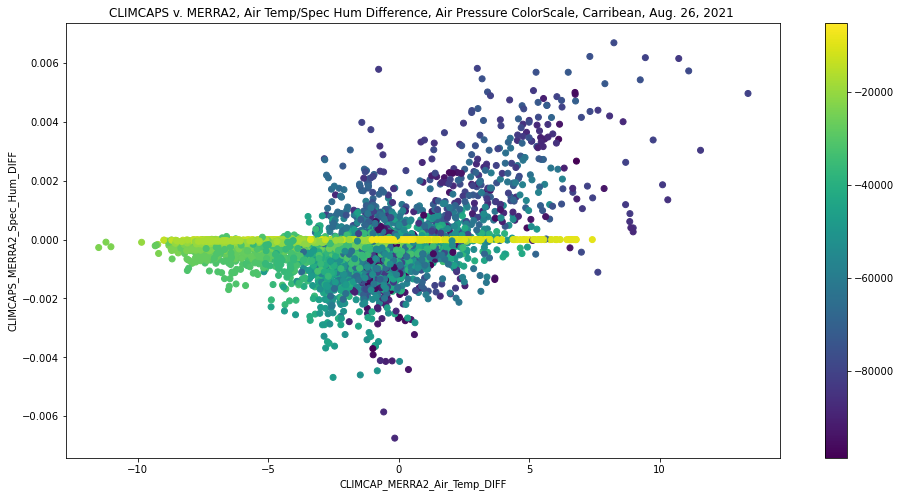

In [70]:
# Scatter Plot, Difference Between Air Temp & Spec Hum (MERRA2 vs N20 CLIMCAPs)
# Color Scale is Spec Hum

plt.figure(figsize=(16,8))
sc=plt.scatter(new_df['CLIMCAPS_N20_MERRA2_DIFF_x'], 
               new_df['CLIMCAPS_N20_MERRA2_DIFF_y'], 
               c=new_df['air_pres']) #,c=0)
#               c=new_df['n20_spec_hum']) #,c=0)
plt.xlabel("CLIMCAP_MERRA2_Air_Temp_DIFF")
plt.ylabel("CLIMCAPS_MERRA2_Spec_Hum_DIFF")
plt.colorbar(sc)
#cbar.set_label('Color', rotation=270,labelpad=25)
plt.title("CLIMCAPS v. MERRA2, Air Temp/Spec Hum Difference, Air Pressure ColorScale, Carribean, Aug. 26, 2021 ")
plt.show()

In [39]:
# Skip
fig=px.scatter_3d(new_df, 
           x="c_lon", 
           y="c_lat",
           z='air_pres_h2o',
           animation_frame="frame", 
           range_color=[min(new_df['CLIMCAPS_N20_MERRA2_DIFF_x']), max(new_df['CLIMCAPS_N20_MERRA2_DIFF_x'])],
           color="CLIMCAPS_N20_MERRA2_DIFF_x",
           color_continuous_scale='jet',
           title='Air Temperature CLIMCAPS(N20) v MERRA2 Aug 26, 2021',
#           text=['N20 Time: ' + str(df['obs_time_utc'][i]) + '<br>Merra2 Time: ' + str(df['time'][i]) + '<br>N20 AirTemp: ' + str(df['air_temp'][i]) + '<br>MERRA air_temp: ' + str(df["t"][i]) for i, row in df.iterrows() ],
        hover_data=['n20_time', 'merra2_time', 'n20_air_temp', 'merra2_air_temp']
    )

fig.write_html("climcaps_merra_air_temp_diff_3d_scatter" + ".html")

In [40]:
# Skip
fig=px.scatter_3d(new_df, 
           x="c_lon", 
           y="c_lat",
           z='air_pres_h2o',
           animation_frame="frame", 
           range_color=[min(new_df['CLIMCAPS_N20_MERRA2_DIFF_y']), max(new_df['CLIMCAPS_N20_MERRA2_DIFF_y'])],
           color="CLIMCAPS_N20_MERRA2_DIFF_y",
           color_continuous_scale='jet',
           title='Specific Humidity CLIMCAPS(N20) v MERRA2 Aug 26, 2021',
#           text=['N20 Time: ' + str(df['obs_time_utc'][i]) + '<br>Merra2 Time: ' + str(df['time'][i]) + '<br>N20 AirTemp: ' + str(df['air_temp'][i]) + '<br>MERRA air_temp: ' + str(df["t"][i]) for i, row in df.iterrows() ],
        hover_data=['n20_time', 'merra2_time', 'n20_spec_hum', 'merra2_spec_hum']
    )

fig.write_html("climcaps_merra_spec_hum_diff_3d_scatter" + ".html")

In [71]:
from sklearn.cluster import KMeans
from sklearn import datasets

x=np.dstack((new_df.CLIMCAPS_N20_MERRA2_DIFF_x, new_df.CLIMCAPS_N20_MERRA2_DIFF_y * 1000.0))
kmeans=KMeans(n_clusters=8)
kmeans.fit(x[0])
print (kmeans.cluster_centers_)
print (kmeans.labels_)

[[-8.84349710e-01 -3.91598192e-03]
 [ 2.60913740e+00  3.48634666e-01]
 [-2.55118710e+00 -3.66153192e-01]
 [ 5.81491878e+00  2.56369433e+00]
 [ 6.91011697e-01 -6.94484609e-02]
 [-4.45479696e+00 -2.74120725e-01]
 [-1.19786648e+00 -1.76008365e+00]
 [-7.15545290e+00 -2.31769995e-01]]
[0 6 6 ... 3 1 4]


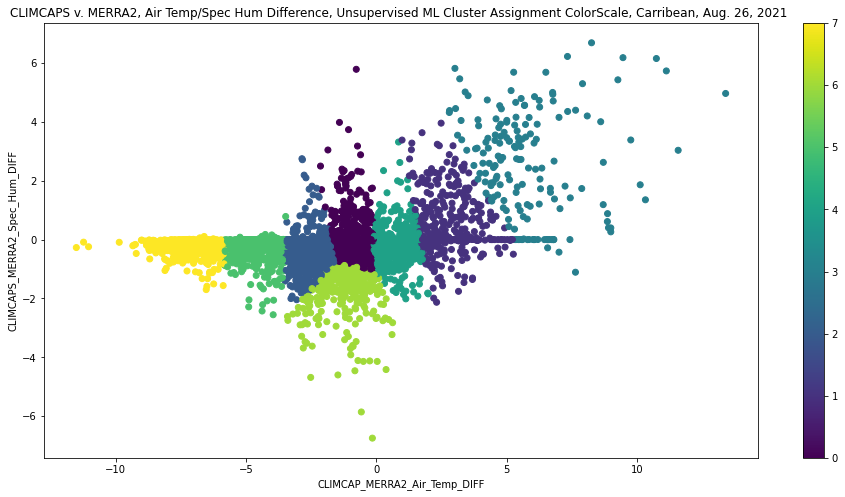

In [72]:
plt.figure(figsize=(16,8))
sc=plt.scatter(x[0][:,[0]], x[0][:,[1]],c=kmeans.labels_)
plt.xlabel("CLIMCAP_MERRA2_Air_Temp_DIFF")
plt.ylabel("CLIMCAPS_MERRA2_Spec_Hum_DIFF")
plt.colorbar(sc)
#cbar.set_label('Color', rotation=270,labelpad=25)
plt.title("CLIMCAPS v. MERRA2, Air Temp/Spec Hum Difference, Unsupervised ML Cluster Assignment ColorScale, Carribean, Aug. 26, 2021 ")
plt.show()

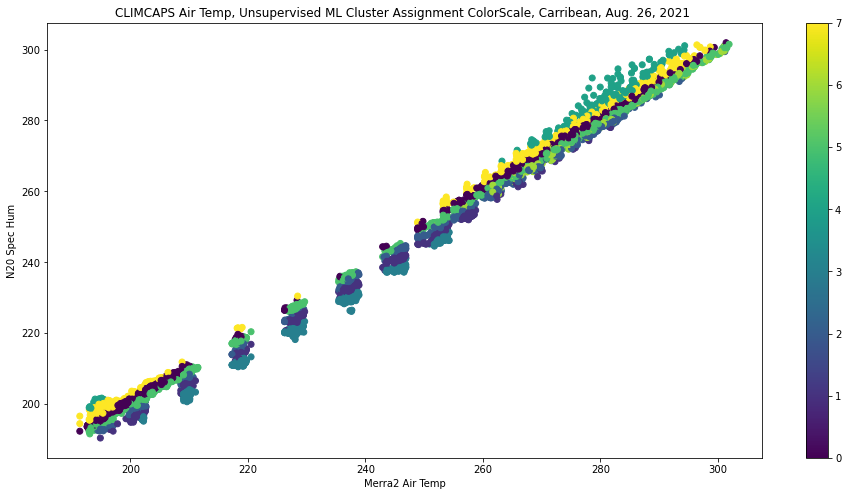

In [43]:
plt.figure(figsize=(16,8))
sc=plt.scatter(new_df['merra2_air_temp'], new_df['n20_air_temp'],c=kmeans.labels_)
plt.xlabel("Merra2 Air Temp")
plt.ylabel("N20 Spec Hum")
plt.colorbar(sc)
#cbar.set_label('Color', rotation=270,labelpad=25)
plt.title("CLIMCAPS Air Temp, Unsupervised ML Cluster Assignment ColorScale, Carribean, Aug. 26, 2021 ")
plt.show()

In [63]:
new_df['cluster']=kmeans.labels_

In [77]:
fig=px.scatter_3d(new_df, 
           x="c_lon", 
           y="c_lat",
           z='air_pres_h2o',
           animation_frame="frame", 
           range_color=[min(new_df['cluster']), max(new_df['cluster'])],
           color="cluster",
           color_continuous_scale='jet',
           title='Specific Humidity & Air Temperature Difference CLIMCAPS(N20) v MERRA2 ML Classification Aug 26, 2021',
#           text=['N20 Time: ' + str(df['obs_time_utc'][i]) + '<br>Merra2 Time: ' + str(df['time'][i]) + '<br>N20 AirTemp: ' + str(df['air_temp'][i]) + '<br>MERRA air_temp: ' + str(df["t"][i]) for i, row in df.iterrows() ],
        hover_data=['n20_time', 'merra2_time', 'n20_spec_hum', 'merra2_spec_hum', 'n20_air_temp', 'merra2_air_temp']
    )

fig.write_html("climcaps_merra_spec_hum_air_temp_ML_Clusters_3d_scatter" + ".html")

In [78]:
# Skip
fig=px.scatter_3d(
           new_df.loc[new_df['cluster'] == 6], 
           x="c_lon", 
           y="c_lat_round_x",
           z='air_pres_h2o',
           animation_frame="frame", 
           range_color=[min(new_df['cluster']), max(new_df['cluster'])],
           color="cluster",
           color_continuous_scale='jet',
           title='Specific Humidity & Air Temperature Difference CLIMCAPS(N20) v MERRA2 ML Classification Aug 26, 2021',
#           text=['N20 Time: ' + str(df['obs_time_utc'][i]) + '<br>Merra2 Time: ' + str(df['time'][i]) + '<br>N20 AirTemp: ' + str(df['air_temp'][i]) + '<br>MERRA air_temp: ' + str(df["t"][i]) for i, row in df.iterrows() ],
           hover_data=['n20_time', 'merra2_time', 'n20_spec_hum', 'merra2_spec_hum', 'n20_air_temp', 'merra2_air_temp']
    )

fig.write_html("climcaps_merra_spec_hum_air_temp_ML_Clusters_3d_scatter_filtered" + ".html")

<h1>Backup Demo</h1>

In [ ]:
# Compare GOES 16 L2 WS and SST and MERRA-2 WS and SST variables -> Machine Learning Example

q="""
with t1 as (
select
 time_base,
 hour(time_base) g_hour,
 longitude,
 latitude,
 sea_surface_temperature,
 wind_speed,
 quality_level
from 
 sci.abi_g16_star_l2p_v2_70 g
where 
g.time_base between timestamp '2021-08-25 17:00' and timestamp '2021-08-25 17:00' 
and hour(time_base) = 17
and g.longitude between -100 and -76
and g.latitude  between 15  and 31
),
t2 as (
select 
 time, 
 date_part,
 hour(date_part) m_hour,
 lon, 
 lat,
 CASE WHEN is_nan(TSKINWTR) THEN TS ELSE TSKINWTR END TSKINWTR,
 sqrt( power(U10M,2) + power(V10M,2) ) WS
from 
 sci.merra_2d m
where date_part between timestamp '2021-08-25' and timestamp '2021-08-25' and hour(time) = 17
and lon between -100 and -76
and lat  between 15 and 31
and is_nan(CASE WHEN is_nan(TSKINWTR) THEN TS ELSE TSKINWTR END) = False
)
select
 t1.time_base,
 t1.longitude,
 t1.latitude,
 t1.g_hour,
 t1.sea_surface_temperature,
 t2.TSKINWTR,
 t2.TSKINWTR - t1.sea_surface_temperature MERRA_G16_SST_DIFF,
 t1.quality_level,
 t2.WS - t1.wind_speed MERRA_G16_WS_DIFF,
 WS,
 wind_speed
from 
 t1, 
 t2
where 
 t2.lat between t1.latitude - 0.25 and t1.latitude + 0.25   
 and t2.lon between t1.longitude - 0.3125 and t1.longitude + 0.3125
"""
df = q2df(q)

In [ ]:
#corr = df.corr()
#corr.style.background_gradient(cmap='coolwarm')
#corr.style.background_gradient(cmap='coolwarm')
print (df.hist(bins=30, figsize = (16,12)))

In [ ]:
df.isnull().values.any()
df[df['MERRA_G16_SST_DIFF'].isna()]

In [ ]:
from sklearn.cluster import KMeans
from sklearn import datasets

x=np.dstack((df.MERRA_G16_WS_DIFF, df.MERRA_G16_SST_DIFF))
kmeans=KMeans(n_clusters=5)
kmeans.fit(x[0])
print (kmeans.cluster_centers_)
print (kmeans.labels_)

In [ ]:
plt.figure(figsize=(12,6))
sc=plt.scatter(x[0][:,[0]], x[0][:,[1]],c=kmeans.labels_)
plt.xlabel("MERRA_G16_WS_DIFF")
plt.ylabel("MERRA_G16_SST_DIFF")
plt.colorbar(sc)
#cbar.set_label('Color', rotation=270,labelpad=25)

plt.show()

In [ ]:
# Map Clusters
df['cluster']=kmeans.labels_
fig = px.scatter_mapbox(df,
              lat="latitude" ,
              lon="longitude",
              color="cluster",
              #animation_frame="date",
              mapbox_style='carto-positron',
                hover_data={'time_base', 'sea_surface_temperature', 'TSKINWTR', 'cluster', 'WS', 'wind_speed'},
                range_color = [ min(df['cluster']), max( df['cluster'] ) ]
              #category_orders={
              #time_col:list(np.sort(sample_df[time_col].unique()))
              #},                  
            #  zoom=10
            )
fig.write_html("map_" + "sst_cluster" + ".html")

In [ ]:
# Map Windspeed differeneces
fig = px.scatter_mapbox(df,
              lat="latitude" ,
              lon="longitude",
#              hover_name="TS",
              color="MERRA_G16_WS_DIFF",
              animation_frame="time_base",
              mapbox_style='carto-positron',
             # hover_data={'TS':":.3f",
             #             'sea_surface_temperature':':.3f'
             #           },
                hover_data={'WS', 'wind_speed', 'MERRA_G16_WS_DIFF'},
                range_color = [min(df['MERRA_G16_WS_DIFF']), max(df['MERRA_G16_WS_DIFF'])]
              #category_orders={
              #time_col:list(np.sort(sample_df[time_col].unique()))
              #},                  
            #  zoom=10
            )
fig.write_html("map_" + "ws_diff" + ".html")

In [ ]:
# Map SST differeneces
fig = px.scatter_mapbox(df,
              lat="latitude" ,
              lon="longitude",
#              hover_name="TS",
              color="MERRA_G16_SST_DIFF",
              animation_frame="time_base",
              mapbox_style='carto-positron',
             # hover_data={'TS':":.3f",
             #             'sea_surface_temperature':':.3f'
             #           },
                hover_data={'TSKINWTR', 'sea_surface_temperature', 'MERRA_G16_SST_DIFF'},
                range_color = [min(df['MERRA_G16_SST_DIFF']), max(df['MERRA_G16_SST_DIFF'])]
              #category_orders={
              #time_col:list(np.sort(sample_df[time_col].unique()))
              #},                  
            #  zoom=10
            )
fig.write_html("map_" + "sst_diff" + ".html")
print (df.hist(bins=30, figsize = (16,12)))

In [ ]:
q="""
CREATE table pmacharr.sst_7day_stats_v2
as (
select
 week(time_base) week, 
 round(longitude, 1)             longitude_10th,
 round(latitude, 1)              latitude_10th,
 avg(sea_surface_temperature)    sst_avg,
 stddev(sea_surface_temperature) sst_stddev,
 min(sea_surface_temperature)    sst_min,
 max(sea_surface_temperature)    sst_max,
 count(*) obs_count
from 
 sci.abi_g16_star_l2p_v2_70 g
where 
hour(time_base) = 17
and g.longitude between -100 and -76
and g.latitude  between 15  and 31
group by 
 1,2,3
order by 2,1,3
)
"""
df = q_ddl(q)

In [ ]:
q="""
select
 g.time_base,
 date_format(g.time_base, '%Y-%m-%d') date,
 g.longitude,
 g.latitude,
 g.sea_surface_temperature,
 t1.sst_avg,
 t1.sst_stddev,
 t1.obs_count,
 (g.sea_surface_temperature - t1.sst_avg) / t1.sst_stddev sst_sigma
from 
 pmacharr.sst_7day_stats t1,  
 sci.abi_g16_star_l2p_v2_70 g
where 
 g.time_base between timestamp '2021-08-24' and timestamp '2021-09-02'
 and round(g.latitude, 1) = t1.latitude_10th   
 and round(g.longitude, 1) = t1.longitude_10th
 and week(time_base) = t1.week
 and hour(time_base) = 17
 and t1.obs_count > 100
 and abs((g.sea_surface_temperature - t1.sst_avg) / t1.sst_stddev) > 3.0
order by 
 2
"""
df=q2df(q)

In [ ]:
# Find the top five Hottest Descending Orbit average 10 x 10 degree tile
q="""
with t1 as (
select
 sat_name_part,
 obs_date_part,
 asc_flag,
 round(lon, -1) lon,
 round(lat, -1) lat,
 avg(surf_air_temp) surf_air_temp_avg,
 count(*) num_obs
from 
 sci.climcaps c
where
 surf_air_temp_qc in ( '0', '1')
 and asc_flag = '0'
group by
    sat_name_part,
    obs_date_part,
    asc_flag,
    4,5
having 
 count(*) > 60
order by
 6 desc
limit 5
)
select 
 c.sat_name_part,
 c.asc_flag,
 c.lon,
 c.lat,
 obs_time_utc,
 surf_air_temp,
 t1.lon,
 t1.lat,
 t1.surf_air_temp_avg,
 t1.num_obs
from 
    sci.climcaps c,
    t1
where
     round(c.lon,-1) = t1.lon
 and round(c.lat, -1) = t1.lat
 and c.sat_name_part = t1.sat_name_part
 and c.obs_date_part = t1.obs_date_part
 and c.asc_flag      = t1.asc_flag
"""
df=q2df(q)
df

In [ ]:
# Map Hottest and Coldest Pixels
fig = px.scatter_mapbox(df,
              lat="lat" ,
              lon="lon",
#              hover_name="TS",
              color="surf_air_temp",
              mapbox_style='carto-positron',
             # hover_data={'TS':":.3f",
             #             'sea_surface_temperature':':.3f'
             #           },
                hover_data={'sat_name_part', 'asc_flag', 'obs_time_utc', 'surf_air_temp'},
                #range_color = [min(df['surf_air_temp']), max(df['surf_air_temp'])]
                range_color = [186, max(df['surf_air_temp'])]
              #category_orders={
              #time_col:list(np.sort(sample_df[time_col].unique()))
              #},                  
            #  zoom=10
            )
fig.write_html("map_" + "hottest_tile" + ".html")

In [158]:
q="""
select date_format(obs_date_time, '%Y-%m-%d') obs_date_part, avg(lon) h_lon, avg(lat) h_lat, min(stormType) h_type,
99000 air_pres,
'n20' sat_name_part,
'1' asc_flag

from 
 climcaps_work_area.hurricane_ida
group by
 date_format(obs_date_time, '%Y-%m-%d')
order by 1
"""
df=q2df(q)
df


92e34284-7833-4556-bf37-c03abf000221 <Future at 0x7f9407e845f8 state=running>
SUCCEEDED
Data Scanned Bytes: 1121
Total Execution Time (ms): 842
Output location: s3://esdis-ems-athena/92e34284-7833-4556-bf37-c03abf000221.csv


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



,obs_date_part,h_lon,h_lat,h_type,air_pres,sat_name_part,asc_flag
0,2021-08-26,-79.57500,17.600000,Tropical Depression,99000,n20,1
1,2021-08-27,-81.83000,20.440000,Hurricane,99000,n20,1
2,2021-08-28,-85.35000,24.225000,Hurricane,99000,n20,1
3,2021-08-29,-89.60500,28.540000,Hurricane,99000,n20,1
4,2021-08-30,-90.64166,30.916666,Hurricane,99000,n20,1
5,2021-08-31,-88.10000,34.475000,Tropical Depression,99000,n20,1
6,2021-09-01,-81.07500,37.875000,Post-Tropical Cyclone,99000,n20,1
7,2021-09-02,-72.95000,40.950000,Post-Tropical Cyclone,99000,n20,1


In [ ]:
# Debugging adding hurrican center to graphic.

df['frame']=df['sat_name_part'] + '_' + df['asc_flag'].astype(str) + '_' + df['obs_date_part']

import plotly.graph_objects as go

fig=go.Figure()
#fig = px.scatter_mapbox(
#                        df, 
#                        lon="irwin_initialLongitude", 
#                        lat="irwin_initialLatitude", 
#                        hover_name="irwin_incidentname", 
#                        hover_data=["irwin_fireDiscoveryDateTime", "irwin_poostate", "filesDistributed"],
#                        color_discrete_sequence=["red"],
#                        size=[ 5 for i in range( df.shape[0] ) ],
#                        zoom=3)

#fig=px.scatter_3d(df, 
#           x="lon", 
#           y="lat",
#           z='air_pres',
#           animation_frame="frame", 
#           range_color=[min(df['air_temp_avg']), max(df['air_temp_avg'])],
#           color="air_temp_avg",
#           color_continuous_scale='jet'
#          )
fig = fig.add_trace(
    px.scatter_3d(
    df,
    x='lon', 
    y='lat',
    z='air_pres',
    animation_frame="frame", 
    range_color=[min(df['air_temp_avg']), max(df['air_temp_avg'])],
    color="air_temp_avg",
    color_continuous_scale='jet'
    )
)

#fig = fig.add_trace(go.Scattermapbox(
#    lon=round(df_buoys['buoy_lon'],2), 
#    lat=round(df_buoys['buoy_lat'],2),
#    mode='markers',
#    marker=go.scattermapbox.Marker(
#            size=10,
#            color=round(df_buoys['temp_diff_C'], 2),
#            cmax=2.0,
#            cmin=-2.0,
#            colorscale='Jet'
#    ),
#    name='Buoy',
#    text=[ '<br>Argo Water Temperature (C): ' + str(round(df_buoys["temp"][i],2))  for i in range(df_buoys.shape[0]) ],
#    hoverinfo='text'    )
#)

#fig.update_layout(mapbox_style="open-street-map",  height=3000)
#fig.update_layout(autosize=False, 
#    width=2000, 
#    height=1200,
#    margin={"r":0,"t":0,"l":0,"b":0})
#fig.update_layout(
#    mapbox=dict(bearing=0, center=go.layout.mapbox.Center(lat=20, lon=-75),pitch=0,zoom=5)
#)
#fig.show("notebook")
fig.write_html("map_" + "x" + ".html")

In [ ]:
# Debugging adding hurricane center to graphic

df['frame']=df['sat_name_part'] + '_' + df['asc_flag'].astype(str) + '_' + df['obs_date_part']

fig=add_trace(px.scatter_3d(df, 
           x="lon", 
           y="lat",
           z='air_pres_lay',
           animation_frame="frame", 
           range_color=[min(df['h2o_vap_mol_lay']), max(df['h2o_vap_mol_lay'])],
           color="h2o_vap_mol_lay",
           color_continuous_scale='jet'
          )
             )



In [ ]:
# Map Hottest and Coldest Pixels
fig = px.scatter_mapbox(df,
              lat="lat" ,
              lon="lon",
#              hover_name="TS",
              color="surf_air_temp",
              mapbox_style='carto-positron',
             # hover_data={'TS':":.3f",
             #             'sea_surface_temperature':':.3f'
             #           },
                hover_data={'sat_name_part', 'asc_flag', 'obs_time_utc', 'surf_air_temp'},
                range_color = [min(df['surf_air_temp']), max(df['surf_air_temp'])]
              #category_orders={
              #time_col:list(np.sort(sample_df[time_col].unique()))
              #},                  
            #  zoom=10
            )
fig.write_html("map_" + "hot_cold_pixels" + ".html")